Before you run the program, please do the following:
1) Match the file name for your Gradescope CSV, your Egrades Roster CSV and your Webwork CSV (downoaded from Gauchospace, not Webwork). They also need to be in the same folder as this program, or you will have to add navegation to the file names. 

2) Make sure your Egrades roster has no perm numbers with letters in them. They are usually at the bottom. If there is a letter (like an X), then the student IDs will likely not match and the program will throw an error. To fix this, locate the student in both the Gradescope and Egrades Roster and use the same numerical perm number for both students. In this iteration, there is a student who has an X in egrades, and after the above tweak I just manually entered his grade when it came time to submit by referencing the finished CSV file. 

3) I was going to write more, but there's WAY more to this particular program and I would need to adapt it to more general use I think. 

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import seaborn as sns
import matplotlib.pyplot as plt


#Import Grade Files
grades = pd.read_csv("Math_34A_Spring_2022_Grades.csv")
roster = pd.read_csv("Math_34A_Spring_2022_Roster.csv")
webwork = pd.read_csv("Math_34A_Spring_2022_Webwork.csv", na_values=["-"]) #Why are nan values represented 
#in "-" in Webwork???




#Renameing "Perm #" to "SID" in Egrades, which may not even be necessary. 
roster.rename(columns = {"Perm #": "SID"}, inplace = True)

#Renaming the same and the Homework column in Webwork
webwork.rename(columns = {"ID number": "SID"}, inplace = True)
webwork.rename(columns = {"External tool:Webwork (Real)": "HWT"}, inplace = True)





#Midterm Merger Function - meant for merging scores for different versions of the same midterm. 
#Note that the .fillna(0) method could be used to add the entried directly, but this would throw off the statistics
def midterm_merger(row):   # row is a Series
    if not math.isnan(row["Midterm 1 Gold"]):
        return row["Midterm 1 Gold"]
    elif not math.isnan(row["Midterm 1 Blue"]):
        return row["Midterm 1 Blue"]
    else:
        return row["Midterm 1 Gold"]

#Midterm 1 Merge
grades["Midterm 1"] = grades.apply(midterm_merger, axis=1)

#grades["Midterm 1"] = grades["Midterm 1 Gold"].fillna(0) + grades["Midterm 1 Blue"].fillna(0)

grades.drop(columns=["Midterm 1 Gold", "Midterm 1 Blue"], axis=1, inplace=True)



#1) Grades List Operations
#Deleting Garbage Columns
junk_column_indices = [i for i, column in enumerate(grades.columns) \
                       if "Max Points" in column or "Submission Time" in column \
                       or "Lateness" in column or column == "section_name" or column == "Email"]
grades.drop(grades.columns[junk_column_indices], axis=1, inplace=True)

#Renaming Columns: Homework and quizzes (In grades df)
quiz_column_names = [name for name in grades.columns if "quiz" in name.lower()]
grades.rename(columns = {name: "Quiz"+" "+str(i+1) for i, name in enumerate(quiz_column_names)}, inplace = True)




#2) Roster Operations
#Pruning Unneccesary Columns from egrades
##Column numbers are used for the drop operation because of the consistency of the registrar's column format. 
##If their column order changes in future quarters/years then you'll have to redo this list by eye and enter the numbers 
##for the columns you want dropped below. Indexing starts at 0. 
#roster.drop(roster.columns[[2,3,4,5,6,7,8,9,10,11,12,13,14,15]], axis=1, inplace=True)
#roster = roster[["Enrl Cd", "SID", "Grade", "ClassLevel", "Major1", "Major2"]]
roster = roster[["Enrl Cd", "SID"]]
webwork = webwork[["SID", "HWT"]]


"""The merge below was halted because one perm # begins with an X, 
and I suspect this forced the data type for everything in the 
column imported to be considered an "object". This was fixed by me 
going into the file and changing the perm number with an X in it 
to match the other perm number. Here are two trouble-shooting commands to help with that issue (commented out):"""
#print(roster.SID)
#print(grades.SID)


#Merge The Grades Lists
grades_merge_one = pd.merge(grades, roster, on="SID", how ="right")
grades_for_submission = pd.merge(webwork, grades_merge_one, on="SID", how ="right")



#Prune more columns from general roster
junk_column_indices = [i for i, column in enumerate(grades_for_submission.columns) \
                       if "Pronouns" in column or "Enroll Code" in column \
                       or "Lateness" in column or column == "section_name" or column == "Email"]
grades_for_submission.drop(grades_for_submission.columns[junk_column_indices], axis=1, inplace=True)



#Scaling the Midterms
grades_for_submission["M1"] = np.round(grades_for_submission["Midterm 1"]*4, decimals=1)
grades_for_submission["M2"] = np.round(100*grades_for_submission["Midterm 2"]/23, decimals=1)
grades_for_submission["M3"] = np.round(100*grades_for_submission["Midterm 3"]/40, decimals=1)
#Drop Midterm Point Columns
grades_for_submission.drop(columns=["Midterm 1", "Midterm 2", "Midterm 3"], axis=1, inplace=True)


#Missing Quiz Corrections -- Ugh!
#Starting with Two full quizzes: Trevor's cover left all of the quizzes out on a table in the tea room
trevor_df = pd.read_csv("Excused Tests/Trevor's Students.csv")
trevor_students = list(trevor_df["SID"])
#Quiz Totals List (by quiz number, index needs to be shifted by 1 of course)
quiz_tot_points = [5, 4, 5, 5, 3, 6, 3, 3, 5, 1]
#Quiz Replacement (100%)
def missed_quiz_replacer(row, list, i):
    if row["SID"] in list:
        return quiz_tot_points[i-1]
    else:
        return row["Quiz "+str(i)]
for i in [4,6]:
    grades_for_submission["Quiz "+str(i)] = grades_for_submission.apply(lambda row: np.round(missed_quiz_replacer(row,
                                                                             trevor_students, i), 
                                                    decimals=1),
                                axis=1)
#Quiz Replacement (100%) for everyone else
for i in range(1,11):
    quiz_df = pd.read_csv("Excused Tests/Quiz "+str(i)+" Excused Students.csv")
    students = list(quiz_df["SID"])
    grades_for_submission["Quiz "+str(i)] = grades_for_submission.apply(lambda row: np.round(missed_quiz_replacer(row,
                                                                             students, i), 
                                                    decimals=1),
                                axis=1)



#Let's sort the columns and shorten the name of the data set (so gfs will be grades_for_submission sorted)
gfs_copy = grades_for_submission.copy()
#first_columns = ["First Name", "Last Name", "Enrl Cd", "SID", "Grade", "ClassLevel", "Major1", "Major2"]
first_columns = ["First Name", "Last Name", "Enrl Cd", "SID"]
gfs_copy.drop(first_columns, axis=1, inplace=True)
gfs_copy = gfs_copy[sorted(gfs_copy.columns)]
gfs = gfs_copy.copy()
for i, info_col in enumerate(first_columns):
    gfs.insert(i, info_col, grades_for_submission[info_col], True)



#Quiz Total Column
quiz_list=["Quiz "+str(i) for i in range(1,len(quiz_column_names)+1)]
gfs["QT"] = gfs[quiz_list].sum(axis=1)*100/39
#Adjusting the Quiz Total to include missing points
missing_quiz_point_multiplier = gfs["Q Reflection for Improvement"].fillna(0)/200
gfs["QTA"] = gfs["QT"] + (100-gfs["QT"])*missing_quiz_point_multiplier


##Final Percent Calculation
#**Final Point Total Here**
final_point_total = 72
gfs["Final"] = np.round(gfs["Final Exam"]*100/final_point_total, decimals=1)


#Replacing Midterm Entries for Excused Absences (that midterm is replaced w/ the final score)
def missed_midterm_replacer(row, list, i):
    if row["SID"] in list:
        return row["Final"]
    else:
        return row["M"+str(i)]   
#for i in range(1,4):
#    gfs["M"+str(i)] = gfs.apply(lambda row: np.round(missed_midterm_replacer(row,
#                                                                             missing_midterm_list[i-1], i), 
#                                                    decimals=1),
#                                axis=1)
for i in range(1,4):
    midterm_df = pd.read_csv("Excused Tests/Midterm "+str(i)+" Excused Students.csv")
    students = list(midterm_df["SID"])
    gfs["M"+str(i)] = gfs.apply(lambda row: np.round(missed_midterm_replacer(row,
                                                                             students, i), 
                                                    decimals=1),
                                axis=1)

#Final Replacement will be done below because we need to replace the final with the midterm average


#Two New Midterm Grade Columns (Raw Average and "MT" that drops the lowest midterm) -- I dropped "Raw Average" below
gfs["Raw Midterm Average"] = gfs.apply(lambda row: (row.fillna(0)["M1"]+row.fillna(0)["M2"]+row.fillna(0)["M3"])/3
                                                                     , axis = 1)
gfs["MT"] = gfs.apply(lambda row: (3*row["Raw Midterm Average"] - np.min([row.fillna(0)["M1"],row.fillna(0)["M2"],
                                                                          row.fillna(0)["M3"]]))/2, axis = 1)
#Adjusting the Midterm Total to include missing points
missing_midterm_point_multiplier = gfs["Exam Reflection for Improvement"].fillna(0)/200
gfs["MTA"] = gfs["MT"] + (100-gfs["MT"])*missing_midterm_point_multiplier
gfs.drop(columns=["Raw Midterm Average"], axis=1, inplace=True)


##Replacing Final Entries for Excused Absences (that midterm is replaced w/ the final score)
def missed_final_replacer(row, list):
    if row["SID"] in list:
        return row["MTA"]
    else:
        return row["Final"]
final_df = pd.read_csv("Excused Tests/Final Exam Excused Students.csv")
final_missed = list(final_df["SID"])
gfs["Final"] = gfs.apply(lambda row: missed_final_replacer(row, final_missed), 
                                axis=1)
#gfs["Final na0"] = gfs["Final"].fillna(0)



#Grade Column
gfs["Grade"] = gfs.apply(lambda row: .1*row["QTA"] + .2*row["HWT"] + .4*row["MTA"] + .3*row.fillna(0)["Final"] + 3,
                        axis=1)
#Letter Grade Assignment Function
def letter_grade_assigner(row):
    num = max(row["Grade"], row["Final"])
    if num > 104:
        return "huh?"
    elif num >= 97:
        return "A+"
    elif num >= 92.5:
        return "A"
    elif num >= 90:
        return "A-"
    elif num >= 87:
        return "B+"
    elif row["Grade"] >= 72.5: #Great Effort Rule - NOT based on higher final grade!
        return "B"
    elif row["Final"] >= 82.5:
        return "B"
    elif row["Final"] >= 80:
        return "B-"
    elif row["Final"] >= 77:
        return "C+"
    elif row["Final"] >= 73:
        return "C"
    elif num >= 70:
        return "C-"
    elif num >= 67:
        return "D+"
    elif num >= 62.5:
        return "D"
    elif num >= 60:
        return "D-"
    else: 
        return "F"
    

#Letter Grade Column
gfs["Letter Grade"] = gfs.apply(lambda row: letter_grade_assigner(row), axis=1)

#ordering columns for Egrades Submission and my sanity
first_columns = ["SID", "Enrl Cd", "Letter Grade", "Final", "MTA", "HWT", "QTA"]
temp_columns = gfs[first_columns]
gfs.drop(columns=first_columns, axis=1, inplace=True)
for (i, col_name) in enumerate(first_columns):
    gfs.insert(i, col_name, temp_columns[col_name])




#Save gfs df to a file
gfs.to_csv('Math_34A_Winter_2022_Grades_python_output.csv', header=True, index=False)



Below is the code for a slimmed-down version of the dataframe with just the three key columns (and they should be in the right order) for submission to Egrades. 

In [2]:
##Slim Format for Submission
"Enrl Cd", "SID"
gfs_slim = gfs[["Enrl Cd", "SID", "Letter Grade"]]
gfs_slim.to_csv('Math 34A Egrades List Spring 22.csv', header=True, index=False)

Grade distribution for the whole class
Letter Grade
A     29
A+    56
A-    24
B     44
B+    17
B-     1
C      2
C+     1
C-     3
D      4
D+     2
D-     1
F     45
Name: Letter Grade, dtype: int64


<AxesSubplot:xlabel='Letter Grade'>

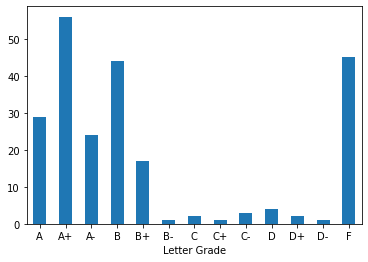

In [3]:
#Letter Grade Distribution
print("Grade distribution for the whole class")
grade_dist = gfs.groupby(by="Letter Grade")
print(grade_dist["Letter Grade"].count())
index = ['F', 'D-', 'D',
         'D+', "C-", "C", "C+", "B-", "B", "B+", "A-", "A", "A+"]
letter_grades = gfs["Letter Grade"].count()
df = pd.DataFrame({'Letter Grade': letter_grades}, index=index)

grade_dist["Letter Grade"].count().plot.bar(rot=0)


 
 Grade distribution for only students who took the final
Letter Grade
A     29
A+    55
A-    24
B     43
B+    16
B-     1
C      2
C+     1
C-     3
D      4
D+     2
F      9
Name: Letter Grade, dtype: int64


<AxesSubplot:xlabel='Letter Grade'>

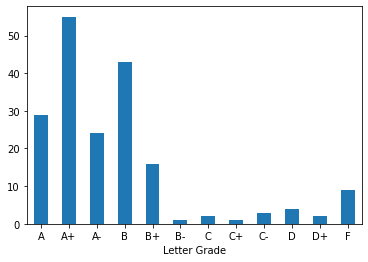

In [4]:
#Letter Grade Distribution  
print("\n","\n","Grade distribution for only students who took the final")
grade_dist = gfs[["Letter Grade", "Final Exam"]].dropna().groupby(by="Letter Grade")
print(grade_dist["Letter Grade"].count())
index = ['F', 'D-', 'D',
         'D+', "C-", "C", "C+", "B-", "B", "B+", "A-", "A", "A+"]
letter_grades = gfs["Letter Grade"].count()
df = pd.DataFrame({'Letter Grade': letter_grades}, index=index)

grade_dist["Letter Grade"].count().plot.bar(rot=0)

   Percentile       Grade      M1      M2      M3      MT      MTA  \
0        100%  103.000000  100.00  100.00  100.00  100.00  100.000   
1         95%  100.563487   98.74   97.80   97.50   96.75   98.300   
2         90%   98.902769   94.00   95.70   95.00   96.00   97.005   
3         85%   97.821231   92.00   91.30   92.50   93.25   95.790   
4         80%   96.436103   88.00   89.10   92.34   91.20   94.660   
5         75%   95.635128   86.00   87.00   90.00   89.40   93.150   
6         70%   93.997436   78.00   84.07   87.50   86.48   92.225   
7         65%   92.187949   72.00   82.60   87.50   85.20   91.040   
8         60%   90.735846   70.00   78.30   85.00   81.63   89.015   
9         55%   89.519385   66.00   73.90   82.50   78.52   87.570   
10        50%   88.053077   62.00   69.60   79.35   76.00   85.050   
11        45%   86.376462   58.20   69.60   76.14   70.10   82.845   
12        40%   84.782667   54.00   65.20   75.00   65.63   81.330   
13        35%   81.1

<function matplotlib.pyplot.show(close=None, block=None)>

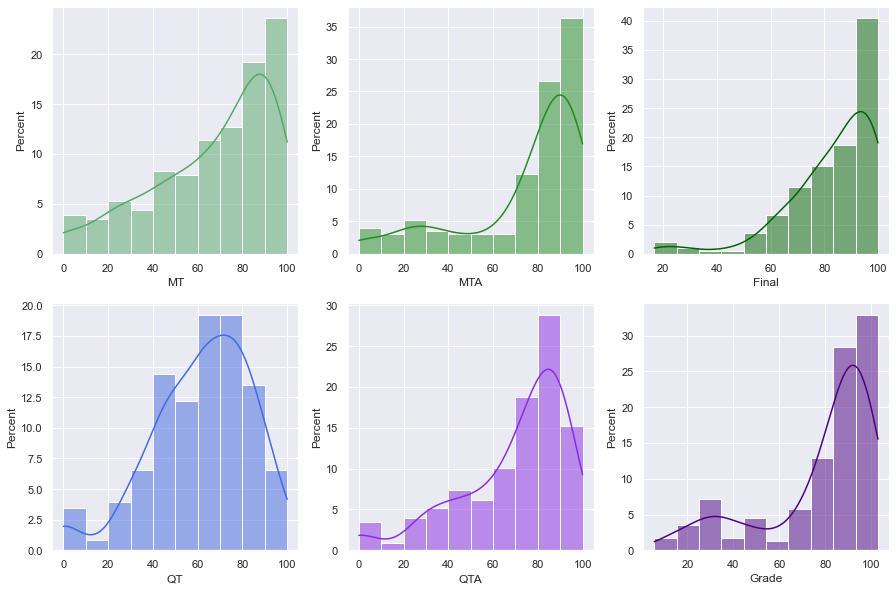

In [5]:
#Making Quantiles for each item
quantiles = pd.DataFrame({
    "Percentile": [str(100-5*n)+"%" for n in range (21)], 
    "Grade": np.quantile([grade for grade in list(gfs["Grade"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "M1": np.quantile([grade for grade in list(gfs["M1"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "M2": np.quantile([grade for grade in list(gfs["M2"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "M3": np.quantile([grade for grade in list(gfs["M3"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "MT": np.quantile([grade for grade in list(gfs["MT"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "MTA": np.quantile([grade for grade in list(gfs["MTA"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
#    "Raw Midterm Average": np.quantile([grade for grade in list(gfs["Raw Midterm Average"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
#    "MTot": np.quantile([grade for grade in list(gfs["Raw Midterm Average"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "QT": np.quantile([grade for grade in list(gfs["QT"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "QTA": np.quantile([grade for grade in list(gfs["QTA"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "HWT": np.quantile([grade for grade in list(gfs["HWT"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "Final": np.quantile([grade for grade in list(gfs["Final"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
})
print(quantiles)


#Plotting Student Scores with Seaborn's histplot
sns.set()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.set_palette("deep")
#Full Color List (some used below): https://matplotlib.org/stable/gallery/color/named_colors.html
sns.histplot(x=gfs["MT"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[0,0], color="g")
sns.histplot(x=gfs["MTA"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[0,1], color="forestgreen")
sns.histplot(x=gfs["Final"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[0,2], color="darkgreen")
sns.histplot(x=gfs["QT"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[1,0], color="royalblue")
sns.histplot(x=gfs["QTA"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[1,1], color="blueviolet")
sns.histplot(x=gfs["Grade"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[1,2], color="indigo")
plt.show

Midterm Trends
AxesSubplot(0.125,0.536818;0.352273x0.343182)
AxesSubplot(0.125,0.125;0.352273x0.343182)
AxesSubplot(0.547727,0.536818;0.352273x0.343182)
AxesSubplot(0.547727,0.125;0.352273x0.343182)


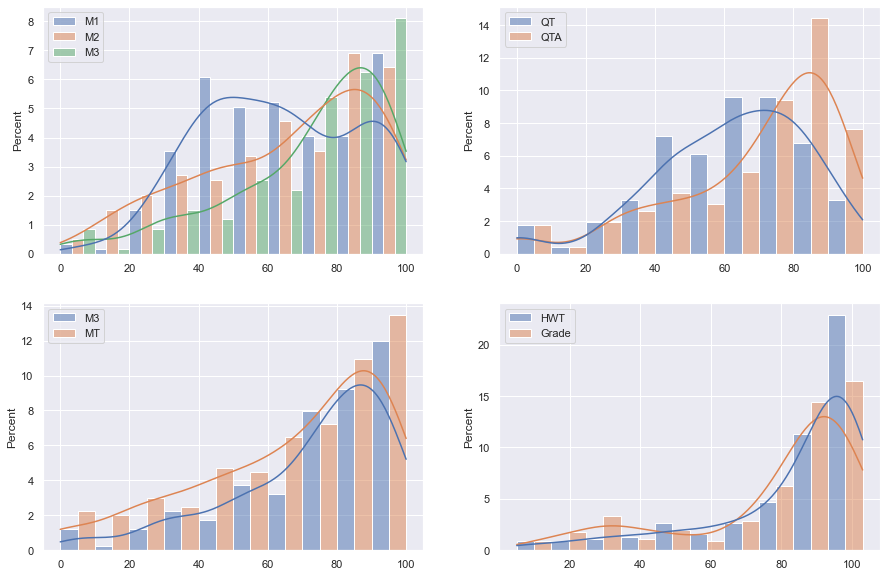

In [6]:
#Midterm Progress in One Vizualization
#sns.displot(gfs["M1"], kde=True, rug=True)
print("Midterm Trends")
sns.set()
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.set_palette("deep")
print(sns.histplot(gfs[["M1", "M2", "M3"]], 
                   kde=True, bins=10, stat="percent", multiple = "dodge", ax=axes[0,0])
     )
print(sns.histplot(gfs[["M3", "MT"]], 
                   kde=True, bins=10, stat="percent", multiple = "dodge", ax=axes[1,0])
     )
print(sns.histplot(gfs[["QT", "QTA"]], 
                   kde=True, bins=10, stat="percent", multiple = "dodge", ax=axes[0,1])
     )
print(sns.histplot(gfs[["HWT", "Grade"]], 
                   kde=True, bins=10, stat="percent", multiple = "dodge", ax=axes[1,1])
     )


In [7]:
#Misc. Stats
print("Misc. Stats:")
print(gfs[["M1", "M2", "M3", 
                             "MT", "Final"]+["Quiz "+str(i) for i in range(1,9)] + ["QT"]+["HWT"]].describe())

Misc. Stats:
               M1          M2          M3          MT       Final  Quiz 1  \
count  219.000000  202.000000  172.000000  229.000000  193.000000   209.0   
mean    63.363470   65.690099   72.573837   67.084279   82.863731     5.0   
std     22.750059   25.441242   22.938776   26.911653   16.941135     0.0   
min      6.000000    0.000000    2.500000    0.000000   16.700000     5.0   
25%     44.000000   47.800000   60.000000   49.500000   75.000000     5.0   
50%     62.000000   69.600000   79.350000   76.000000   87.500000     5.0   
75%     86.000000   87.000000   90.000000   89.400000   95.800000     5.0   
max    100.000000  100.000000  100.000000  100.000000  100.000000     5.0   

           Quiz 2      Quiz 3  Quiz 4      Quiz 5      Quiz 6      Quiz 7  \
count  206.000000  201.000000   201.0  190.000000  199.000000  179.000000   
mean     1.747573    3.865672     5.0    1.463158    3.763819    1.687151   
std      1.145242    1.052077     0.0    1.067168    2.271807 